In [1]:
import cv2
import numpy as np
import PIL
from math import pi, ceil, floor
import math
from matplotlib import pyplot as plt
import random
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import skimage.io
from scipy import ndimage as ndi
from statistics import mean
import glob
from PIL import Image
from tqdm import tqdm
import os
import pathlib

print("Done")

Done


In [2]:
def do_image(original, thresh_lo, thresh_hi, erode_val, gauss_val, exponent, gauss_val2, R, G, B):
    original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    r_channel, g_channel, b_channel = cv2.split(original)
    color_channels = [r_channel, g_channel, b_channel]
    alpha_channel = np.ones(b_channel.shape, dtype=b_channel.dtype) * 50 #creating a dummy alpha channel image.
    default_vals = [R, G, B]
        
    border_int = 3
    img = cv2.copyMakeBorder(cv2.cvtColor(original, cv2.COLOR_BGR2GRAY), border_int, border_int, border_int, border_int, cv2.BORDER_CONSTANT, value=255)
    
    ret, thresh = cv2.threshold(img, thresh_lo, thresh_hi, cv2.THRESH_BINARY)
    dist = cv2.distanceTransform(thresh, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)
    dist = cv2.GaussianBlur(dist, (gauss_val, gauss_val), 0)
    dist = dist[border_int:img.shape[0]-border_int, border_int:img.shape[1]-border_int]
    norm_dist = cv2.normalize(dist, None, 0, 1.0, cv2.NORM_MINMAX)
    alpha_channel = cv2.bitwise_not((255 * norm_dist).astype(b_channel.dtype))
    
    kernel = np.ones((erode_val, erode_val), np.uint8)
    alpha_channel = cv2.erode(alpha_channel, kernel)
    
    img_RGBA = Image.fromarray(cv2.cvtColor(cv2.merge((r_channel, g_channel, b_channel, alpha_channel)), cv2.COLOR_BGRA2RGBA))
    
    return img_RGBA, alpha_channel

def weight_func(markers, markers2):
    new_running_sum = 0
    for i, row in enumerate(markers):
        for j, cell in enumerate(row):
            if markers[i][j] == markers2[i][j]:
                new_running_sum = new_running_sum + 1
            else:
                new_running_sum = new_running_sum - 1
    return abs(new_running_sum)

print("Done")

Done


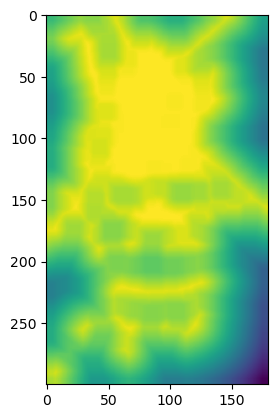

Starting sum: 44576


Iteration 1: 100%|███████████████████████████| 3200/3200 [01:21<00:00, 39.50combo/s, Best=7778, Records=3200, Sum=9966]


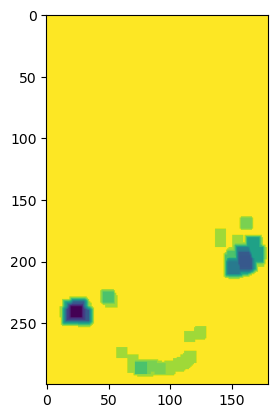

Starting sum: 3218


Iteration 2:  11%|███                        | 361/3200 [00:09<01:12, 39.42combo/s, Best=3218, Records=3561, Sum=43960]

KeyboardInterrupt



In [5]:
# starting parameters
thresh_lo = 50
thresh_hi = 140
erode_val = 10
gauss_val = 9
exponent = 0.18
gauss_val2 = 3
R = 80
G = 146
B = 180
variability = 1

img = cv2.cvtColor(cv2.imread("new_download2.png"), cv2.COLOR_BGR2RGB)
img2 = cv2.bitwise_not(cv2.imread("new_download.png"))
best_params = [thresh_lo, thresh_hi, erode_val, gauss_val, exponent, gauss_val2, R, G, B]

record = []
last = []
iterations = 10
for iteration in range(iterations):
    starting_params = best_params
    if starting_params == last:
        break
    else:
        _, start_markers = do_image(img, *starting_params)
        compare_img, start_markers2 = do_image(img2, *starting_params)
        plt.imshow(start_markers)
        plt.show()
        start_running_sum = weight_func(start_markers, start_markers2)
        print("Starting sum: %d" % (start_running_sum))
        best_sum = start_running_sum
        options = []
        
        for i in range(floor(starting_params[1] - variability), ceil(starting_params[1] + variability)):
            for j in range(floor(starting_params[0] - variability), ceil(starting_params[0] + variability)):
                for k in range(floor(starting_params[2] - variability), ceil(starting_params[2] + variability)):
                    for l in [1, 3, 5, 7, 9]:
                        for m in range(floor(int(starting_params[4] * 100) - variability), ceil(int(starting_params[4] * 100) + variability)):
                            for n in [1, 3, 5, 7, 9]:
                                for o in range(floor(starting_params[6]-variability), ceil(starting_params[6]+variability)):
                                    for p in range(floor(starting_params[7]-variability), ceil(starting_params[7]+variability)):
                                        for q in range(floor(starting_params[8]-variability), ceil(starting_params[8]+variability)):
                                            options.append([i, j, k, l, m, n, o, p, q])
                                            
        with tqdm(total=len(options), unit="combo", desc=str("Iteration %s" % (iteration + 1))) as pbar:
            for r in options:
                if r in record:
                    continue
                else:
                    _, markers = do_image(img, *r)
                    new_running_sum = weight_func(markers, start_markers2)
                    if new_running_sum < best_sum:
                        best_sum = new_running_sum
                        best_params = r
                    record.append(r)
                pbar.update(1)
                pbar.set_postfix(Sum = new_running_sum, Best = best_sum, Records = len(record), refresh=True)


original_img, markers = do_image(img, *best_params)
fig, axs = plt.subplots(ncols = 4, figsize=(15, 15))
axs[0].imshow(compare_img)
axs[1].imshow(start_markers2)
axs[2].imshow(original_img)
axs[3].imshow(markers)

new_running_sum = weight_func(markers, start_markers2)
print(new_running_sum)
print(*best_params)